In [10]:
import time
from langchain_core.output_parsers import StrOutputParser
from langchain_core.prompts import ChatPromptTemplate
from langchain_groq import ChatGroq
from langchain_ollama import OllamaLLM, ChatOllama
from pydantic import BaseModel, Field
from langchain_chroma import Chroma
from langchain_ollama import OllamaEmbeddings
from langgraph.graph import StateGraph, MessagesState, START, END
from IPython.display import Image, display
import requests
from langchain.schema import Document

In [11]:
from langchain_community.tools.tavily_search import TavilySearchResults

web_search_tool = TavilySearchResults(k=3)
web_search_tool

TavilySearchResults(api_wrapper=TavilySearchAPIWrapper(tavily_api_key=SecretStr('**********')))

In [12]:
from typing import List
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, MessagesState, START, END


class GraphState(TypedDict):
    """
    Represents the state of our graph.

    Attributes:
        connection: web connection
        question: question
        generation: LLM generation
        documents: list of documents
    """
    connection: bool = False
    question: List[str]
    generation: str   
    documents: List[str]

In [13]:
llm = ChatGroq(temperature=0, model_name= "llama-3.3-70b-versatile")
# llm = OllamaLLM(base_url="http://localhost:11434", model="llama3.2:latest")

In [14]:
def web_connection(state):
    print("---WEB CONNECTION---")
    print(f">>> state: {state}")
    res = check_internet(state)
    return {"connection": res}

def check_internet(state):
    """Check internet connection by pinging a website."""
    
    print("---CHECK INTERNET CONNECTION---")
    try:
        response = requests.get("https://www.google.com", timeout=2)
        # If the request is successful, we assume internet is ON
        if response.status_code == 200:
            # print("Internet is ON")
            return "ON"
    except requests.ConnectionError:
        # If there is a connection error, we assume internet is OFF
        # print("Internet is OFF")
        return "OFF"


def web_search(state):
    """
    Web search based on the re-phrased question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates documents key with appended web results
    """

    print("---WEB SEARCH---")

    merged_question = ""   ## 메모리 기능을 위해 앞선 질문까지 모아서 인풋풋
    for i in state["question"]:
        if "question" in list(i.keys()):
            merged_question = merged_question + "\n" + i["question"]
        else: pass
    
    question = merged_question[-400:] # "error": "Query is too long. Max query length is 400 characters."
    print(f">> merged_question_length: {len(question)}")
    print(question)

    docs = web_search_tool.invoke({"query": question})
    print(">>> wed search docs")
    print(docs)
    web_results = "\n".join([d["content"] for d in docs])
    web_results = Document(page_content=web_results)

    return {"documents": web_results, "question": question}

def generate(state):
    """
    Generate answer

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): New key added to state, generation, that contains LLM generation
    """
    print("---GENERATE---")
    question = state["question"]
    documents = state["documents"]

    # RAG generation
    prompt = ChatPromptTemplate.from_messages([
        ("human", 
        """You are a smart AI assistant. 
        Use the following pieces of retrieved context to answer the question. 
        Generate compact answer including specified numbers, fomulas in the point of technical specifications.
        if there are multiple questions, focusing on the last question. 
        other quetions should not be answered and just be considered as referring information.
        If you don't know the answer, just say that you don't know. 
        Question: {question} 
        Context: {context} 
        Answer:"""),
        ])



    rag_chain = prompt | llm | StrOutputParser()

    generation = rag_chain.invoke({"context": documents, "question": question})
    return {"generation": generation}


# Prompt
system = """You a question re-writer that converts an input question to a better version that is optimized \n 
     for vectorstore retrieval. Look at the input and try to reason about the underlying semantic intent / meaning."""
re_write_prompt = ChatPromptTemplate.from_messages(
    [
        ("system", system),
        (
            "human",
            "Here is the initial question: \n\n {question} \n Formulate an improved question.",
        ),
    ]
)
%timeit
question_rewriter = re_write_prompt | llm | StrOutputParser()



def transform_query(state):
    """
    Transform the query to produce a better question.

    Args:
        state (dict): The current graph state

    Returns:
        state (dict): Updates question key with a re-phrased question
    """

    print("---TRANSFORM QUERY---")
    question = state["question"]
    documents = state["documents"]

    # Re-write question
    better_question = question_rewriter.invoke({"question": question})
    return {"documents": documents, "question": better_question}


class GradeHallucinations(BaseModel):
    """Binary score for hallucination present in generation answer."""

    binary_score: str = Field(
        description="Answer is grounded in the facts, 'yes' or 'no'"
    )

class GradeAnswer(BaseModel):
    """Binary score to assess answer addresses question."""
    binary_score: str = Field(
        description="Answer addresses the question, 'yes' or 'no'"
    )


def grade_generation_v_documents_and_question(state):
    """
    Determines whether the generation is grounded in the document and answers question.

    Args:
        state (dict): The current graph state

    Returns:
        str: Decision for next node to call
    """

    print("---CHECK HALLUCINATIONS---")
    question = state["question"]
    documents = state["documents"]
    generation = state["generation"]
    
    print(">>> document")
    print(documents)
    print(">>> generation")
    print(generation)

    
    # Prompt
    system = """You are a grader assessing whether an LLM generation is grounded in / supported by a set of retrieved facts. \n 
        Give a binary score 'yes' or 'no'. 'Yes' means that the answer is grounded in / supported by the set of facts."""
    hallucination_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "Set of facts: \n\n {documents} \n\n LLM generation: {generation}"),
        ]
    )
    structured_llm_grader = llm.with_structured_output(GradeHallucinations)
    hallucination_grader = hallucination_prompt | structured_llm_grader

    score = hallucination_grader.invoke(
        {"documents": documents, "generation": generation}
    )
    grade = score.binary_score

    # Prompt
    system = """You are a grader assessing whether an answer addresses / resolves a question \n 
        Give a binary score 'yes' or 'no'. Yes' means that the answer resolves the question."""
    answer_prompt = ChatPromptTemplate.from_messages(
        [
            ("system", system),
            ("human", "User question: \n\n {question} \n\n LLM generation: {generation}"),
        ]
    )
    structured_llm_grader = llm.with_structured_output(GradeAnswer)
    answer_grader = answer_prompt | structured_llm_grader

    # Check hallucination
    if grade == "yes":
        print("---DECISION: GENERATION IS GROUNDED IN DOCUMENTS---")
        # Check question-answering
        print("---GRADE GENERATION vs QUESTION---")
        score = answer_grader.invoke({"question": question, "generation": generation})
        grade = score.binary_score
        if grade == "yes":
            print("---DECISION(Useful): GENERATION ADDRESSES QUESTION---")
            return "useful"
        else:
            print("---DECISION(Not Useful): GENERATION DOES NOT ADDRESS QUESTION---")
            return "not useful"
    else:
        print("---DECISION(Not Supported): GENERATION IS NOT GROUNDED IN DOCUMENTS, RE-TRY---")
        return "not supported"





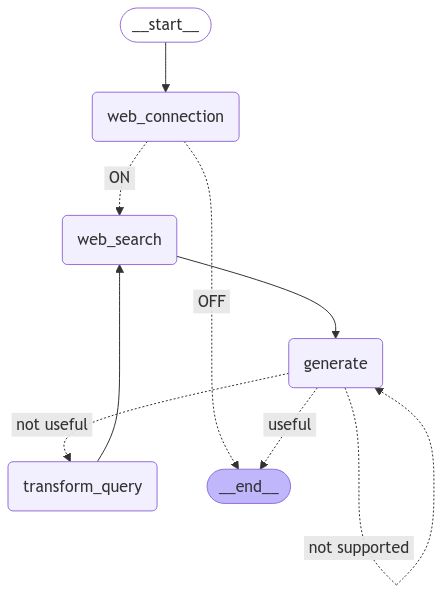

In [15]:
def web_builder(state):
    web_builder = StateGraph(state)
    web_builder.add_node("web_connection", web_connection)
    web_builder.add_node("web_search", web_search)
    web_builder.add_node("generate", generate)
    web_builder.add_node("transform_query", transform_query)

    web_builder.add_edge(START, "web_connection")
    web_builder.add_conditional_edges(
        "web_connection",
        check_internet,
        {
            "ON": "web_search",
            "OFF": END,
        },
    )
    web_builder.add_edge("web_search", "generate")
    web_builder.add_conditional_edges(
        "generate",
        grade_generation_v_documents_and_question,
        {
            "not supported": "generate",
            "useful": END,
            "not useful": "transform_query",
        },
    )
    web_builder.add_edge("transform_query", "web_search")
    return web_builder.compile()

graph = web_builder(state = GraphState)
display(Image(graph.get_graph().draw_mermaid_png()))

In [16]:
import time
inputs = []
question = "회사 리더들에게 안내할 오늘의 중대재해 예방 가이드를 작성해주세요. 최근의 안전사고 사례를 포함해주세요."
input = {"role": "user", "question": question}
inputs.append(input)
inputs

[{'role': 'user',
  'question': '회사 리더들에게 안내할 오늘의 중대재해 예방 가이드를 작성해주세요. 최근의 안전사고 사례를 포함해주세요.'}]

In [17]:
temp = []
async for event in graph.astream_events({'question': inputs}, version="v1"):
    if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
        # print(event)
        try:
            response = event['data']['chunk'].content  # groq
            temp.append(response)
            print(response, end="")   
            time.sleep(0.1)
        except:
            response = event['data']['chunk']  # ollama
            temp.append(response)
            print(response, end="")    
            time.sleep(0.1)
        finally: pass
    else: pass

---WEB CONNECTION---
>>> state: {'question': [{'role': 'user', 'question': '회사 리더들에게 안내할 오늘의 중대재해 예방 가이드를 작성해주세요. 최근의 안전사고 사례를 포함해주세요.'}]}
---CHECK INTERNET CONNECTION---
---CHECK INTERNET CONNECTION---
---WEB SEARCH---
>> merged_question_length: 59

회사 리더들에게 안내할 오늘의 중대재해 예방 가이드를 작성해주세요. 최근의 안전사고 사례를 포함해주세요.
>>> wed search docs
[{'url': 'https://현대안전.com/25/?bmode=view&idx=11149951', 'content': '2021 사례로 보는 중대재해예방 가이드(고용노동부)입니다. 2021-교육혁신실-865-사례로-보는-중대재해예방-가이드.pdf. 32541KB; 0. 7월 사고사망 일일현황 속보 종합 안전보건관리체계 구축을 위한 7가지 체크리스트 -'}, {'url': 'https://www.seumedu.kr/data/safe/2021+사례로+보는+중대재해예방+가이드.pdf', 'content': "4 고용노동부 2021년 사례로 보는 중대재해예방 가이드 02 업종별 사망사고 현황 Ⅰ. 건설업 규모별 최근 3년('18~'20년) 건설업 공사금액 50억 미만 소규모 현장 사망사고 비율은 68.3%(937명)를 차지하여 가장 높은 비율 점유-공사금액 1억~50억 미만 현장 45.4%(623명), 1억 미만 현장 22.9%(314명), 120억"}, {'url': 'https://www.data.go.kr/data/15100290/fileData.do', 'content': '한국산업안전보건공단_안전보건미디어자료(사례로 보는 중대재해예방 가이드)_20211223: 분류체계: 공공질서및안전 - 안전관리: 제공기관: 한국산업안전보건공단 관리부서명: 디지털계획부: 관리부서 전화번호: 

AttributeError: 'str' object has no attribute 'keys'

In [40]:
total_res = "".join(temp[:])
inputs.append({"role": "ai", "content": total_res})
print(inputs)
print(len(inputs))

[{'role': 'user', 'question': 'what is wig ship?'}, {'role': 'ai', 'content': 'Based on the provided context, a WIG ship, also known as a WIG craft, is a type of vessel that can operate very close to the surface of the water. The term "WIG" is not explicitly defined in the given context, but it can be inferred that it refers to "Wing-In-Ground" or "Ground-Effect" technology, which allows the craft to fly close to the surface, taking advantage of the ground effect to generate lift and reduce drag.\n\nFrom a technical perspective, WIG craft can be considered as a hybrid between an aircraft and a ship, as they use the ground effect to generate lift and can operate in both air and water environments. The technical specifications of a WIG ship may include:\n\n* Operating altitude: typically very close to the surface, often less than 10-15 meters (33-49 feet)\n* Speed: can vary depending on the design and purpose of the craft, but typically ranges from 100-500 km/h (62-310 mph)\n* Lift-to-dr

In [41]:
question = "why is it so useful?"
input = {"role": "user", "question": question}
inputs.append(input)
inputs

[{'role': 'user', 'question': 'what is wig ship?'},
 {'role': 'ai',
  'content': 'Based on the provided context, a WIG ship, also known as a WIG craft, is a type of vessel that can operate very close to the surface of the water. The term "WIG" is not explicitly defined in the given context, but it can be inferred that it refers to "Wing-In-Ground" or "Ground-Effect" technology, which allows the craft to fly close to the surface, taking advantage of the ground effect to generate lift and reduce drag.\n\nFrom a technical perspective, WIG craft can be considered as a hybrid between an aircraft and a ship, as they use the ground effect to generate lift and can operate in both air and water environments. The technical specifications of a WIG ship may include:\n\n* Operating altitude: typically very close to the surface, often less than 10-15 meters (33-49 feet)\n* Speed: can vary depending on the design and purpose of the craft, but typically ranges from 100-500 km/h (62-310 mph)\n* Lift-to

In [42]:
temp = []
async for event in graph.astream_events({'question': inputs}, version="v1"):
    if event['event'] == 'on_chat_model_stream' or event['event'] == 'on_llm_stream':
        # print(event)
        try:
            response = event['data']['chunk'].content  # groq
            temp.append(response)
            print(response, end="")   
            time.sleep(0.1)
        except:
            response = event['data']['chunk']  # ollama
            temp.append(response)
            print(response, end="")    
            time.sleep(0.1)
        finally: pass
    else: pass

---WEB CONNECTION---
>>> state: {'question': [{'role': 'user', 'question': 'what is wig ship?'}, {'role': 'ai', 'content': 'Based on the provided context, a WIG ship, also known as a WIG craft, is a type of vessel that can operate very close to the surface of the water. The term "WIG" is not explicitly defined in the given context, but it can be inferred that it refers to "Wing-In-Ground" or "Ground-Effect" technology, which allows the craft to fly close to the surface, taking advantage of the ground effect to generate lift and reduce drag.\n\nFrom a technical perspective, WIG craft can be considered as a hybrid between an aircraft and a ship, as they use the ground effect to generate lift and can operate in both air and water environments. The technical specifications of a WIG ship may include:\n\n* Operating altitude: typically very close to the surface, often less than 10-15 meters (33-49 feet)\n* Speed: can vary depending on the design and purpose of the craft, but typically ranges

RateLimitError: Error code: 429 - {'error': {'message': 'Rate limit reached for model `llama-3.3-70b-versatile` in organization `org_01hrm502bcfvcas4j2ppdwhsxf` on : Limit 100000, Used 99857, Requested 596. Please try again in 6m30.825s. Visit https://console.groq.com/docs/rate-limits for more information.', 'type': '', 'code': 'rate_limit_exceeded'}}